# Dataset
Choose a machine learning appropriate dataset and import it into Python. If you are using a classification dataset, your target must be one-hot encoded. You will need to import the dataset and it may not be one we have used previously in class. Finish this assignment by splitting the dataset into training and testing sets.
The dataset should have at least 500 observations. I need to approve the dataset before you start working on it.
Include the name of the dataset and a link to download it in your notebook. Save the notebook as HTML and turn in as a zip.
5 Points

## NOTES TO SELF:
- remove outliers (jonathans run that didn't get a good prediction, and maybe zeros)


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import plotly.express as px





# formatting our dataframes
pd.options.display.float_format = '{:.6f}'.format

#plt.style.use('dark_background')
plt.style.use('default')

# https://www.ginifab.com/feeds/pms/color_picker_from_image.php
name = ''
    
def scatter(var1,var2,df, who = name):
    # Simple red scatter plot with an alpha of .4
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
    if who == 'ALL':
        groups = df.groupby('Runner')
        for name, group in groups:
            plt.plot(group[var1], group[var2],alpha = .3, marker='o', linestyle='', markersize=4, label=name)
        plt.legend()
    else:
        plt.scatter(df[var1],df[var2], alpha = .4, color = 'red')
    plt.xlabel(var1);
    plt.ylabel(var2);
    plt.title('%s: %s vs %s'%(who.title(), var2,var1));
    #plt.locator_params(axis = 'x',nbins=4)
    plt.show()
    
def scatter_categorical(var1,var2,df, sortby, who = name): 
    # Simple scatter plot to graph categorical data var1 = categorical
    df.sort_values(sortby, inplace = True)
    plt.scatter(df[var1],df[var2], alpha = .4, color = 'red')
    plt.xlabel(var1);
    plt.ylabel(var2);
    plt.title('%s: %s vs %s'%(who.title(), var2,var1));
    #plt.set_xticklabels(days)
    #plt.locator_params(axis = 'x',nbins=4)
    plt.show()
    

def scatter_categorical_colored(var1,var2, var3,df, sortby, scale = False, who = name): 
    # Scatter plot to graph categorical data with a third variables, built for var1 = day
    # https://matplotlib.org/stable/tutorials/colors/colormaps.html cmap
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html
    fig = plt.figure(figsize= (8,4))
    df.sort_values(sortby, inplace = True)
    var3_data = df[var3]
    scaled = (var3_data - var3_data.min() )/ (var3_data.max() - var3_data.min())
    if scale:
        c_vals = scaled
    else:
        c_vals = var3_data
    plt.scatter(df[var1],df[var2], alpha = .4, c = c_vals, cmap = 'seismic')
    plt.xlabel(var1);
    plt.ylabel(var2);
    plt.title('%s: %s vs %s'%(who.title(), var2,var1));
    #plt.set_xticklabels(days)
    #plt.locator_params(axis = 'x',nbins=4)
    
    plt.colorbar(label = var3, extendrect= False, extendfrac = None,  orientation = 'vertical')
    plt.show()

    
def get_data(name):
    if name.lower() == 'wilks':
        who = 'Activities_sophia_wilks.csv'
    elif name.lower() == 'munoz':
        who = 'Activities_cole_munoz.csv'
    elif name.lower() == 'goetsch':
        who = 'Activities_jonathan_goetsch.csv'
    return pd.read_csv(who)



C:\Users\menam\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ModuleNotFoundError: No module named 'yellowbrick'

## Clean Data

In [2]:
def split_time(x):
    # Split Time by the formats used 00:00:00, 00:00.0, 00:00.00.0, 00:00:00.00.0    01:06:37.99.9
    # print(x)
    if x.count('.') == 1:
        time = x.split(':')
        return float(time[0]) * 60 + float(time[1])
    elif  x.count('.') == 2:
        if x.count(':') == 1:
            time = x.split(':')[1].split('.')
            return float(time[0]) * 60 + float(time[1])
        elif x.count('.') == 2:
            time = x.split(':')
            mins = time[-1].split('.')
            return float(time[0]) * 24 * 60 * 60 + float(time[1]) * 60 * 60 + float(mins[0]) * 60 + float(mins[1])
    else:
        time = x.split(':')
        return float(time[0]) * 60 **2 + float(time[1]) * 60 + float(time[2]) 

def time_to_seconds(df,var):
    # convert time to seconds using the function split_time()
    return df[var].apply(lambda x: split_time(x))
    
def pace_to_seconds(df,var):
    # convert pace to seconds from the format used in pace 00:00
    return df[var].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]) if x.count(':') == 1 else int(x.split('.')[0]))

def fix_dtype(df):
    # fix the dtype of ['Date', 'Distance'] 
    df['Date'] = pd.to_datetime(df['Date'])
    df['Distance'] = df['Distance'].astype(float)
    return df

def create_vars(df):
    # creating variables from 'Date'
    df['Day'] = df['Date'].dt.day_name()
    df['Hour'] = df['Date'].dt.hour
    df['Minute'] = df['Date'].dt.minute  # splitting the minute and hour might confuse the ML model. That's a question for Dr. Al-Khassaweneh
    df['Weekday'] = df['Date'].dt.weekday
    # df_cleaned['Date'].dt.dayofweek # monday = 0 https://www.datasciencemadesimple.com/get-day-of-week-pandas-python-2/
    return df

def remove_dash(df,var):
    return df[var].replace('--','0')

def remove_comma_retype(df, var):
    # remove columns from strings that should be ints
    return df[var].apply(lambda x: int(re.sub(',', '', x)))  
    
def clean_data(df):
    # Preproccess data so that we can run our predictive models
    
    # remove rows that are all empty, then reset the index 
    df = df.dropna(how = 'all').reset_index().drop('index', axis = 1) 
    
    # Only looking at the running activities
    df = df[df['Activity Type'] == 'Running']
    
    # grouping columns by how they need to be cleaned
    cols = df.columns.tolist()
    time_cols = [ 'Time', 'Best Lap Time','Moving Time', 'Elapsed Time']
    pace_cols = ['Avg Pace','Best Pace']
    comma_cols = ['Calories','Total Ascent','Total Descent', 'Min Elevation', 'Max Elevation']
    dashed_cols = ['Total Ascent', 'Total Descent', 'Min Elevation',  'Max Elevation','Avg Pace', 'Best Pace']

    # remove '--' from columns that have it (run before cleaning others)
    for col in cols:
        # print(dash_col)
        df[col] = remove_dash(df,col)
    
    # convert time and pace into seconds
    for time_col in time_cols:
        #print(time_col)
        df[time_col] = time_to_seconds(df,time_col)
    for pace_col in pace_cols:
        df[pace_col] = pace_to_seconds(df, pace_col)
        
    # remove commas and retype the columns that need it
    for comma_col in comma_cols:
        # print(comma_col)
        df[comma_col]  = remove_comma_retype(df, comma_col)
    
    # fix the data type of cols: ['Date' ]
    df = fix_dtype(df)
    
    # Create 'Day'
    df = create_vars(df)  
    
   
    return df


def get_all(names):
    # all runner data
    df = pd.DataFrame()
    for name in names:
        runner = clean_data(get_data(name))
        runner.insert(0,'Runner', name)
        df = pd.concat([df,runner])
    df = df[(df['Avg HR'] != 56) & (df['Max HR'] != 187)] # remove jonathans watch malfunction
    return df

def get_df(name):
    # Return the dataset for ML
    
    if name in ['wilks', 'munoz', 'goetsch']:
        return clean_data(get_data(name))
        print(name)
    elif name == 'ALL':
        return get_all(['wilks', 'munoz', 'goetsch'])
        print(name)
    else:
        print('Please enter wilks, munoz, goetsch, or ALL')
        
def get_X_y(df):
    y = df['Avg HR']
    X = df.drop(['Avg HR','Runner'], axis = 1)
    return X,y

def get_MSE(X_test,y_test):
    # return mean square error
    return np.mean((regr.predict(X_test) - y_test) ** 2)

def get_R2(X_test,y_test):
    #return R2
    return regr.score(X_test, y_test)

In [6]:
# Testing out if the functions will work
# 'wilks', 'munoz', 'goetsch'
name = 'wilks' 
df_activities = get_data(name)
df_cleaned = clean_data(df_activities)
df_all = get_all(['wilks', 'munoz', 'goetsch'])

wilks
munoz
goetsch


In [14]:
print(df_cleaned.columns.tolist())
for col in df_cleaned.columns.tolist():
    print(col + ',')

['Activity Type', 'Date', 'Favorite', 'Title', 'Distance', 'Calories', 'Time', 'Avg HR', 'Max HR', 'Aerobic TE', 'Avg Run Cadence', 'Max Run Cadence', 'Avg Pace', 'Best Pace', 'Total Ascent', 'Total Descent', 'Avg Stride Length', 'Avg Vertical Ratio', 'Avg Vertical Oscillation', 'Avg Ground Contact Time', 'Avg Run Cadence.1', 'Max Run Cadence.1', 'Training Stress Score®', 'Avg Power', 'Max Power', 'Grit', 'Flow', 'Avg. Swolf', 'Avg Stroke Rate', 'Total Reps', 'Dive Time', 'Min Temp', 'Surface Interval', 'Decompression', 'Best Lap Time', 'Number of Laps', 'Max Temp', 'Moving Time', 'Elapsed Time', 'Min Elevation', 'Max Elevation', 'Day', 'Hour', 'Minute', 'Weekday']
Activity Type,
Date,
Favorite,
Title,
Distance,
Calories,
Time,
Avg HR,
Max HR,
Aerobic TE,
Avg Run Cadence,
Max Run Cadence,
Avg Pace,
Best Pace,
Total Ascent,
Total Descent,
Avg Stride Length,
Avg Vertical Ratio,
Avg Vertical Oscillation,
Avg Ground Contact Time,
Avg Run Cadence.1,
Max Run Cadence.1,
Training Stress Score®

## Models
Predicting Avg Heart Rate:
 - Linear Regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

Notes:
 - Train test split: https://www.geeksforgeeks.org/how-to-split-a-dataset-into-train-and-test-sets-using-python/


### Multiple Linear Regression
(Make into Functions)

mean Residual sum of squares: 0.0008888133617529285
Variance score: 0.9923149100587827
Coefficient of Determination (R^2):  0.9922827913888234


,ALL
Time,-0.050244
Best Pace,0.069123
Elapsed Time,-0.044355
Avg Pace,-0.024054
Max HR,0.905442
Aerobic TE,0.096383
Avg Run Cadence,-0.004709
Max Run Cadence,-0.027695
Total Ascent,0.022401
Total Descent,-0.043027


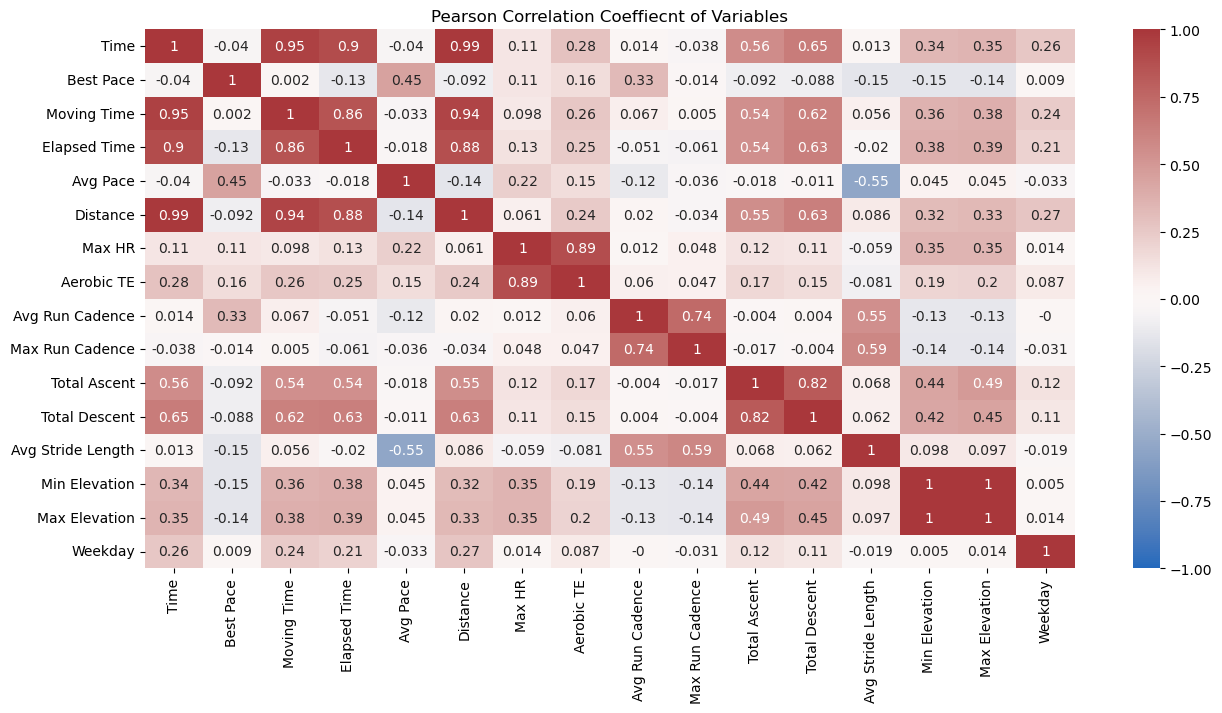

In [3]:
name = 'ALL'
df = get_df(name)

# The variables we will use for prediction
target = 'Avg HR'
predictors = [target,'Time','Best Pace','Moving Time', 'Elapsed Time', 'Avg Pace',
    'Distance',  'Max HR','Aerobic TE','Avg Run Cadence', 'Max Run Cadence',
    'Total Ascent','Total Descent', 'Avg Stride Length', 'Avg Ground Contact Time','Min Temp','Max Temp', 'Min Elevation',
       'Max Elevation', 'Weekday']

# Removing variables that only have one unique entry. This removes varialbes that do not change for this person
nunique = df[predictors].nunique()
predictors = nunique[nunique > 1].index.tolist()

# Dataset of only our predicting variables and the target prediction
df_predictors = df[predictors]

# Normalize the Data 
# https://towardsdatascience.com/data-normalization-with-pandas-and-scikit-learn-7c1cc6ed6475
# MaxAbsScaler()
how_normal = 'MaxAbs'
if how_normal == 'MaxAbs':
    scaler = MaxAbsScaler() # create an abs_scaler object
    scaler.fit(df_predictors) # calculate the maximum absolute value for scaling the data using the fit method
    scaler.max_abs_ # the maximum absolute values calculated by the fit method
    scaled_data = scaler.transform(df_predictors) # transform the data using the parameters calculated by the fit method (the maximum absolute values)
    df_normalized = pd.DataFrame(scaled_data, columns=df_predictors.columns) # store the results in a data frame
# MinMaxScaler()
if how_normal == 'MinMax':
    scaler = MinMaxScaler() # create a scaler object
    df_normalized = pd.DataFrame(scaler.fit_transform(df_predictors), columns=df_predictors.columns) # fit and transform the data

# Correlation of vairables in x_train ( if they are correlated we can use only one)
# https://datagy.io/python-correlation-matrix/
corr = df_normalized[[x for x in predictors if x != target]].corr().round(3) # correlation of everything but the target variable
fig, ax = plt.subplots(figsize = (15,7))
sns.heatmap(corr, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', ax = ax)
ax.set(title = 'Pearson Correlation Coeffiecnt of Variables')

# Remove highly correlated variables
# https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python
upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
df_normalized.drop(to_drop, axis = 1, inplace = True)

# Create Train, and Testing Data
X = df_normalized.iloc[:,1:]   
y = df_normalized.iloc[:,0] # Avg HR is at the zeroth position in this dataset
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=5)

# Build the model and fit it onto our dataset
regr = LinearRegression()
regr.fit(X_train, y_train)

# pipeline with polynomial regression
#regr = Pipeline([('poly', PolynomialFeatures(degree=1)),
#                  ('linear', LinearRegression(fit_intercept=True))])



# The mean square error
print("mean Residual sum of squares:", (np.mean((regr.predict(X_test) - y_test) ** 2)))

# Return the coefficient of determination of the prediction.  
# (The coefficient of determination (R² or r-squared) is a statistical measure in a regression model that determines the proportion of variance in the dependent variable that can be explained by the independent variable. 
# In other words, the coefficient of determination tells one how well the data fits the model (the goodness of fit).)
# Also called: Explained variance score: 1 is perfect prediction
print("Variance score:", get_R2(X_test, y_test))

# Testing how far our away our predictions are away from the actual result
y_predicted = regr.predict(X_test)
R_square = r2_score(y_predicted, y_test) 
print('Coefficient of Determination (R^2): ', R_square) 



# Coeffieicent of each variable
pd.DataFrame(pd.Series(regr.coef_,X_train.columns), columns = [name])





MSE (x_test and y_test): 0.000993620062891159
Variance score: 0.9922273858358088
Coefficient of Determination (R^2):  0.9922034650816194


,ALL
Time,-0.045021
Best Pace,0.067714
Elapsed Time,-0.052469
Avg Pace,-0.022442
Max HR,0.909277
Aerobic TE,0.090952
Avg Run Cadence,-0.000292
Max Run Cadence,-0.020239
Total Ascent,0.011915
Total Descent,-0.060564


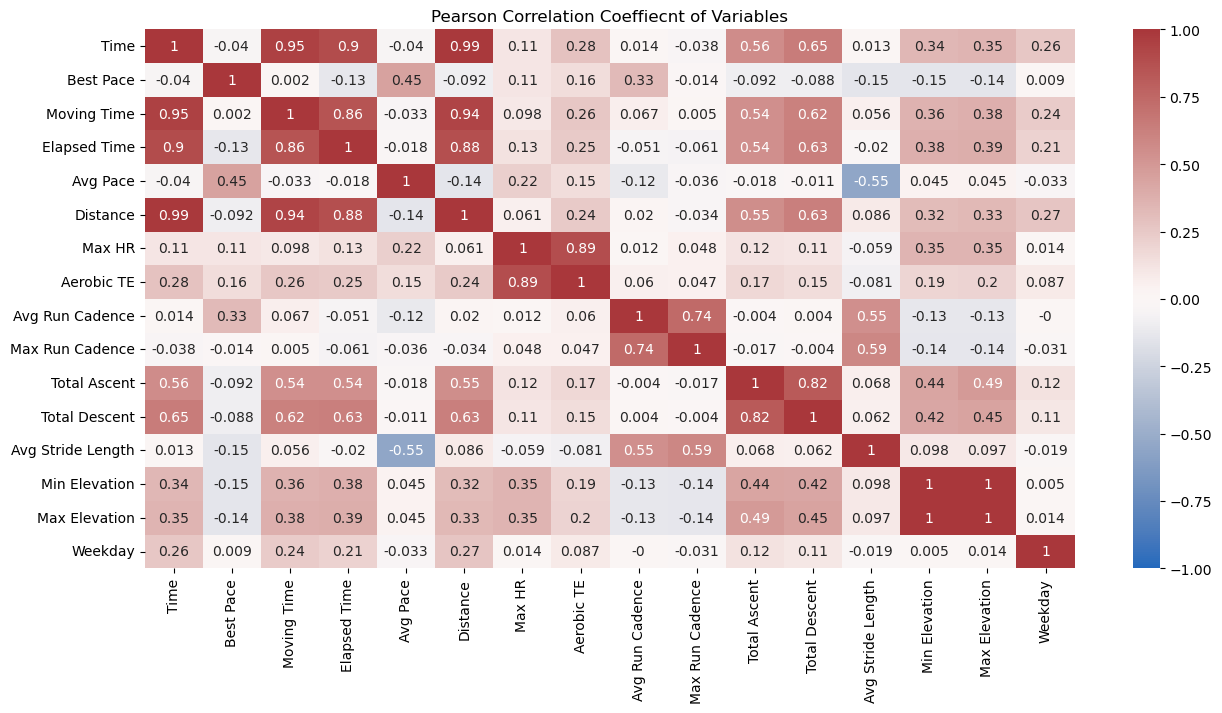

In [53]:
# I don't want to mess with the code above and break it so I will copy and paste it here
name = 'ALL'
df = get_df(name)

# The variables we will use for prediction
target = 'Avg HR'
predictors = [target,'Time','Best Pace','Moving Time', 'Elapsed Time', 'Avg Pace',
    'Distance',  'Max HR','Aerobic TE','Avg Run Cadence', 'Max Run Cadence',
    'Total Ascent','Total Descent', 'Avg Stride Length', 'Avg Ground Contact Time','Min Temp','Max Temp', 'Min Elevation',
       'Max Elevation', 'Weekday']

# Removing variables that only have one unique entry. This removes varialbes that do not change for this person
nunique = df[predictors].nunique()
predictors = nunique[nunique > 1].index.tolist()

# Dataset of only our predicting variables and the target prediction
df_predictors = df[predictors]

# Normalize the Data 
# https://towardsdatascience.com/data-normalization-with-pandas-and-scikit-learn-7c1cc6ed6475
# MaxAbsScaler()
how_normal = 'MaxAbs'
if how_normal == 'MaxAbs':
    scaler = MaxAbsScaler() # create an abs_scaler object
    scaler.fit(df_predictors) # calculate the maximum absolute value for scaling the data using the fit method
    scaler.max_abs_ # the maximum absolute values calculated by the fit method
    scaled_data = scaler.transform(df_predictors) # transform the data using the parameters calculated by the fit method (the maximum absolute values)
    df_normalized = pd.DataFrame(scaled_data, columns=df_predictors.columns) # store the results in a data frame
# MinMaxScaler()
if how_normal == 'MinMax':
    scaler = MinMaxScaler() # create a scaler object
    df_normalized = pd.DataFrame(scaler.fit_transform(df_predictors), columns=df_predictors.columns) # fit and transform the data

# Correlation of vairables in x_train ( if they are correlated we can use only one)
# https://datagy.io/python-correlation-matrix/
corr = df_normalized[[x for x in predictors if x != target]].corr().round(3) # correlation of everything but the target variable
fig, ax = plt.subplots(figsize = (15,7))
sns.heatmap(corr, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', ax = ax)
ax.set(title = 'Pearson Correlation Coeffiecnt of Variables')

# Remove highly correlated variables
# https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python
upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
df_normalized.drop(to_drop, axis = 1, inplace = True)

# add the runner to the normalized data
df_normalized.insert(1,'Runner',df['Runner'].values)

# split the dataframes by who completed the activity
munoz = df_normalized[df_normalized['Runner'] == 'munoz']
wilks = df_normalized[df_normalized['Runner'] == 'wilks']
goetsch = df_normalized[df_normalized['Runner'] == 'goetsch']

# Get X and y for every athelete
X_munoz,y_munoz = get_X_y(munoz)
X_wilks, y_wilks = get_X_y(wilks)
X_goetsch, y_goetsch = get_X_y(goetsch)

# split X_train,X_test, y_train, and y_test for each athlete
X_train_munoz,X_test_munoz,y_train_munoz, y_test_munoz =  train_test_split(X_munoz,y_munoz, test_size = .2,random_state =5)
X_train_wilks,X_test_wilks,y_train_wilks, y_test_wilks = train_test_split(X_wilks,y_wilks, test_size = .2,random_state =5)
X_train_goetsch,X_test_goetsch,y_train_goetsch, y_test_goetsch = train_test_split(X_goetsch,y_goetsch, test_size = .2,random_state =5)

# Concat training and testing data that has 80:20 split having a testing data form each athlete
X_train = pd.concat([X_train_wilks,X_train_munoz,X_train_goetsch])
X_test = pd.concat([X_test_wilks,X_test_munoz,X_test_goetsch])
y_train = pd.concat([y_train_wilks,y_train_munoz,y_train_goetsch])
y_test = pd.concat([y_test_wilks,y_test_munoz,y_test_goetsch])

# Shuffle the training data so it doesn't see all wilks first then all munoz. 
X_train = X_train.sample(frac = 1)
y_train = y_train.reindex(X_train.index)

# Build the model and fit it onto our dataset
regr = LinearRegression()
regr.fit(X_train, y_train)

# pipeline with polynomial regression
#regr = Pipeline([('poly', PolynomialFeatures(degree=1)),
#                  ('linear', LinearRegression(fit_intercept=True))])



# The mean square error
print("MSE (x_test and y_test):", get_MSE(X_test,y_test))

# Return the coefficient of determination of the prediction.  
# (The coefficient of determination (R² or r-squared) is a statistical measure in a regression model that determines the proportion of variance in the dependent variable that can be explained by the independent variable. 
# In other words, the coefficient of determination tells one how well the data fits the model (the goodness of fit).)
# Also called: Explained variance score: 1 is perfect prediction


print("Variance score:", get_R2(X_test, y_test))

# Testing how far our away our predictions are away from the actual result
y_predicted = regr.predict(X_test)
R_square = r2_score(y_predicted, y_test) 
print('Coefficient of Determination (R^2): ', R_square) 



# Coeffieicent of each variable
pd.DataFrame(pd.Series(regr.coef_,X_train.columns), columns = [name])





In [56]:
print(get_MSE(X_test_munoz,y_test_munoz))
print(get_MSE(X_test_wilks,y_test_wilks))
print(get_MSE(X_test_goetsch,y_test_goetsch))

0.0016647746494068841
0.0006331391253737443
0.0007368680730264589


In [59]:
# Taking a closer look at how well our model does
#if how_normal == 'MaxAbs':
#    max_hr = abs(df['Avg HR']).max()
#    y_predicted = pd.Series(y_predicted, index = y_test.index)
#    predictions = pd.DataFrame([y_test.reindex(), y_predicted.reindex()], index = ['True HR', 'Predicted HR']).T
#    predictions = abs(predictions) * max_hr
#    predictions['Difference'] = predictions['True HR'] - predictions['Predicted HR']
#predictions

# What does our model do to the hwhole dataset
if how_normal == 'MaxAbs':
    every_x = df_normalized.drop([target, 'Runner'], axis = 1)
    y_predicted = regr.predict(every_x)
    max_hr = abs(df['Avg HR']).max()
    y_predicted = pd.Series(y_predicted, index = every_x.index)
    predictions = pd.DataFrame([list(df['Runner']),list(df_normalized[target]),list(y_predicted)], index = ['Runner','True HR','Predicted HR']).T
    predictions.iloc[:,1:] = abs(predictions.iloc[:,1:]) * max_hr 
    predictions['Difference'] = predictions['True HR'] - predictions['Predicted HR']
predictions

,Runner,True HR,Predicted HR,Difference
0,wilks,160.000000,164.772500,-4.772500
1,wilks,155.000000,148.284483,6.715517
2,wilks,152.000000,165.990529,-13.990529
3,wilks,163.000000,151.939676,11.060324
4,wilks,169.000000,164.091183,4.908817
...,...,...,...,...
2111,goetsch,154.000000,144.827799,9.172201
2112,goetsch,168.000000,170.410266,-2.410266
2113,goetsch,0.000000,2.232938,-2.232938
2114,goetsch,149.000000,137.547542,11.452458


In [74]:
#predictions[(predictions['Runner'] == 'goetsch') & (predictions['True HR'] < 10)]
goetsch[goetsch['Avg HR'] == 0]


,Avg HR,Runner,Time,Best Pace,Elapsed Time,Avg Pace,Max HR,Aerobic TE,Avg Run Cadence,Max Run Cadence,Total Ascent,Total Descent,Avg Stride Length,Min Elevation,Weekday
1150,0.000000,goetsch,0.480510,0.381262,0.143437,0.315233,0.000000,0.420000,0.914141,0.738462,0.098849,0.104175,0.531250,0.069816,0.833333
1159,0.000000,goetsch,0.315346,0.283859,0.093542,0.313822,0.000000,0.240000,0.904040,0.776923,0.034934,0.034592,0.540179,0.071678,0.000000
1162,0.000000,goetsch,0.188341,0.000000,0.055868,0.228491,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.833333
1180,0.000000,goetsch,0.331382,0.399814,0.098299,0.332863,0.000000,0.260000,0.909091,0.750000,0.061929,0.062028,0.508929,0.069816,0.333333
1195,0.000000,goetsch,0.056186,0.000000,1.000000,0.338505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2107,0.000000,goetsch,0.001053,0.431354,0.000313,0.377292,0.000000,0.000000,0.898990,0.715385,0.001191,0.000000,0.450893,0.069816,1.000000
2108,0.000000,goetsch,0.393422,0.370130,0.116701,0.313117,0.000000,0.000000,0.904040,0.715385,0.050417,0.050497,0.540179,0.077147,0.666667
2109,0.000000,goetsch,0.015568,0.187384,0.021458,0.187588,0.000000,0.000000,0.797980,0.869231,0.005161,0.003976,0.334821,0.069816,0.500000
2113,0.000000,goetsch,0.470678,0.333024,0.139618,0.282793,0.000000,0.000000,0.929293,0.757692,0.162366,0.161034,0.580357,0.069118,1.000000


C:\Users\menam\AppData\Local\Temp\ipykernel_11936\1591662396.py:6: UserWarning: Legend does not support 'Black' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(['Black','Orange','Green'],['Munoz','Wilks','Goetsch'])
C:\Users\menam\AppData\Local\Temp\ipykernel_11936\1591662396.py:6: UserWarning: Legend does not support 'Orange' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(['Black','Orange','Green'],['Munoz','Wilks','Goetsch'])
C:\Users\menam\AppData\Local\Temp\ipykernel_11936\1591662396.py:6: UserWarning: Legend does not support 'Green' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.leg

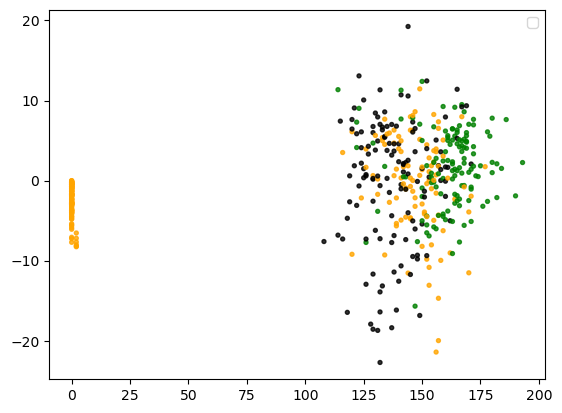

In [100]:
sample_predictions = predictions.sample(n = 500)
sample_predictions = sample_predictions.sort_values('True HR',ascending = True).reindex() # .drop('index',inplace = True)
colormap = {'munoz':'black','goetsch':'orange','wilks':'green'}
plt.scatter(sample_predictions['True HR'],sample_predictions['Difference'], 
            alpha = .8, s = 8,cmap = colormap, c = sample_predictions['Runner'].map(colormap))
plt.legend(['Black','Orange','Green'],['Munoz','Wilks','Goetsch'])
#plt.scatter(sample_predictions.index,sample_predictions['Predicted HR'], marker = '8', color = 'orange', alpha = .7, s = 8)

In [57]:
fig = px.box(predictions, y='Difference', x = 'Runner')
fig.update_layout(title_text='True Avg HR Minus Predicted Avg HR')
fig.show()

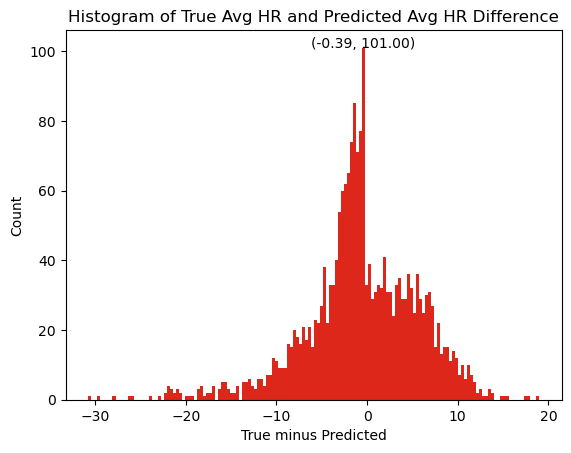

In [54]:
#plt.boxplot(predictions['Difference']);
def add_max_hist(hist, ax):
    # place the bin edge and count in that bin onto a histogram
    maxs = hist.iloc[hist['Count'].argmax()]
    ax.text(maxs[1],maxs[0],'(%.2f, %.2f)'%(maxs[1],maxs[0]),ha = 'center');
fig, ax = plt.subplots()
n, bins, patches = ax.hist(predictions['Difference'], bins = 150, align = 'left', color = '#dd271a');
ax.set(title = 'Histogram of True Avg HR and Predicted Avg HR Difference', xlabel = 'True minus Predicted',ylabel = 'Count' );
hist = pd.DataFrame([n, bins], index = ['Count','Left Edge of Bin']).T
add_max_hist(hist,ax)


# Plotting the Data

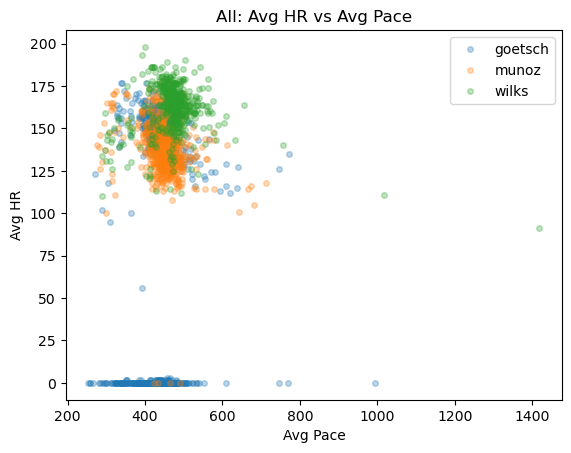

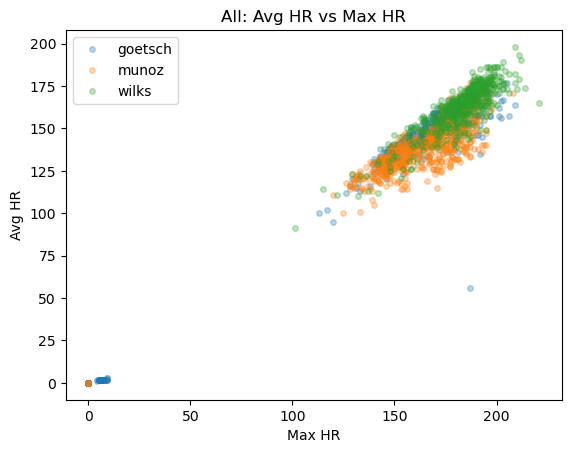

In [15]:
#scatter('Moving Time','Elapsed Time')
#scatter('Avg Pace','Best Pace')
scatter('Avg Pace','Avg HR', df_all, who = 'ALL')
scatter('Max HR','Avg HR',df_all, who = 'ALL')
#scatter('Avg HR','Avg Pace', df_cleaned)
#scatter('Time','Avg Pace', clean_data(get_data('munoz')))
#scatter('Time','Avg Pace', clean_data(get_data('wilks')))
#scatter('Time','Avg Pace', df_who)
#scatter('Moving Time','Avg Pace', df_who)
#scatter('Max HR','Avg HR', df_who)
#scatter('Hour','Avg Pace', df_cleaned) # , c = df.index, cmap = 'hot_r' 
#scatter_categorical('Max HR','Avg HR',clean_data(get_data('goetsch')), 'Weekday', who = 'goetsch') # I want something like a violing plot
#scatter_categorical_colored('Day','Avg Pace','Moving Time',df_cleaned, 'Weekday', scale = False) # I want something like a violing plot
#scatter_categorical_colored('Day','Avg Pace','Max HR',df_cleaned, 'Weekday', scale = False) # I want something like a violing plot
#scatter_categorical_colored('Day','Avg Pace','Max HR',df_cleaned, 'Weekday', scale = False) # I want something like a violing plot


NameError: name 'how_normal' is not defined

NameError: name 'box' is not defined

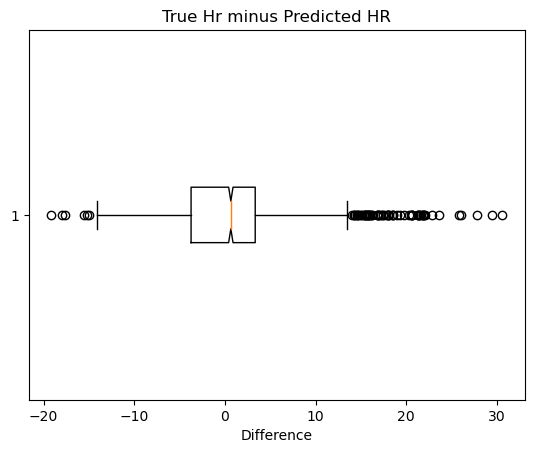

In [47]:
plt.boxplot(predictions['Difference'], notch = True, vert= False, manage_ticks = True);
plt.title('True Hr minus Predicted HR');
plt.xlabel('Difference');
#print(box)

In [53]:
df[df['Avg HR'] == predictions[predictions['Difference']  < - 40 ]['True HR'].iloc[0]]


,Runner,Activity Type,Date,Favorite,Title,Distance,Calories,Time,Avg HR,Max HR,...,Max Temp,Moving Time,Elapsed Time,Min Elevation,Max Elevation,Day,Hour,Minute,Weekday,Total Strokes
241,goetsch,Running,2022-04-03 10:14:40,False,DuPage County Running,13.100000,972,5143.000000,56.000000,187.000000,...,0.000000,5141.000000,5143.000000,604,780,Sunday,10,14,6,0


In [22]:
#predictions[predictions['True HR'] == 0]['Difference'].sort_values(ascending = True)
#predictions[predictions['True HR'] == 0]
df[df['Avg HR'] == 0] 
# we do well on 

,Runner,Activity Type,Date,Favorite,Title,Distance,Calories,Time,Avg HR,Max HR,...,Max Temp,Moving Time,Elapsed Time,Min Elevation,Max Elevation,Day,Hour,Minute,Weekday,Total Strokes
411,munoz,Running,2022-01-03 10:45:29,False,El Paso County Running,10.000000,1177,4339.000000,0.000000,0.000000,...,0.000000,4338.000000,4366.000000,5563,5845,Monday,10,45,0,NaN
412,munoz,Running,2022-01-02 12:01:41,False,Pueblo Running,16.010000,1876,7849.000000,0.000000,0.000000,...,0.000000,7845.000000,8764.000000,4639,4911,Sunday,12,1,6,NaN
687,munoz,Running,2021-06-19 08:21:22,False,Colorado Springs Running,14.000000,1639,5919.000000,0.000000,0.000000,...,0.000000,5917.000000,6460.000000,6004,6152,Saturday,8,21,5,NaN
689,munoz,Running,2021-06-18 06:17:56,False,Pueblo Running,8.880000,1054,4119.000000,0.000000,0.000000,...,0.000000,4117.000000,4668.000000,4642,4946,Friday,6,17,4,NaN
1,goetsch,Running,2022-10-15 09:54:29,False,Romeoville Running,9.180000,1050,4105.000000,0.000000,0.000000,...,0.000000,4099.000000,4131.000000,600,686,Saturday,9,54,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047,goetsch,Running,2020-03-29 08:41:44,False,Plainfield Running,1.040000,113,9.000000,0.000000,0.000000,...,0.000000,551.000000,9.000000,600,604,Sunday,8,41,6,0
1049,goetsch,Running,2020-03-27 14:27:41,False,DuPage County Running,7.570000,827,3361.000000,0.000000,0.000000,...,0.000000,3359.000000,3361.000000,663,702,Friday,14,27,4,0
1050,goetsch,Running,2020-03-26 08:40:49,False,8 Strides,0.500000,67,133.000000,0.000000,0.000000,...,0.000000,9.000000,618.000000,600,604,Thursday,8,40,3,0
1057,goetsch,Running,2020-03-22 09:18:37,False,DuPage County Running,10.010000,1094,4021.000000,0.000000,0.000000,...,0.000000,4017.000000,4021.000000,594,780,Sunday,9,18,6,0


Count              206.000000
Left Edge of Bin    -0.884175
Name: 126, dtype: float64

In [46]:
maxs = hist.iloc[hist['Count'].argmax()]
maxs[1]

-0.8841747856662323

In [120]:
row = 400
print('%s\'s Actual HR: %d' %(df_all.iloc[row]['Runner'], df_all.iloc[row]['Avg HR']))
cols = [x for x in X_train if x != target]
regr.predict(np.array(pd.Series(df_all.iloc[row][cols], cols)).reshape(1,-1))
# I think we need to unscale the model?

wilks's Actual HR: 179


C:\Users\menam\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([-122.88664199])

In [52]:

# why are the predictions so close! 
#scaler.inverse_transform(y_predicted)

def invTransform(scaler, data):
    # we want to make predictions that are unscaled, but we fit our scaler on more than one column, so we feed in our data with the same number of zero columns
    dummy = pd.DataFrame(np.zeros((len(data), scaler.n_features_in_)))
    dummy[0] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=dummy.columns)
    return dummy[0].values

#invTransform(scaler,y_test)

array([ nan, 155.,  nan,  nan, 169.,  nan,  nan,  nan,  nan,  nan,  nan,
        nan, 184.,  nan,  nan, 131.,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan, 165.,  nan,  nan,  nan,  nan,  nan,  nan,
       158.,  nan, 164.,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan, 166.,  nan,  nan,  nan, 152.,  nan,  nan, 166.,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan, 152., 156., 175.,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan, 158.,  nan,
       122.,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan, 179.,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan, 147.,  nan, 157.,  nan,  nan, 174.,
       160.,  nan,  nan, 172.,  nan, 167.,  nan,  nan,  nan,  nan,  nan,
       163., 159.,  nan,  nan, 145.,  nan,  nan, 161.,  nan, 178.,  nan,
        nan,  nan,  nan, 170.,  nan,  nan, 177.,  n

## Logistic Regression (Guessing Runner)
 - https://machinelearningknowledge.ai/python-sklearn-logistic-regression-tutorial-with-example/

Confusion matrix:
 [[733   0  39]
 [  4 518   4]
 [ 24   0 402]]
Training accuracy: 95.8817 %


C:\Users\menam\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


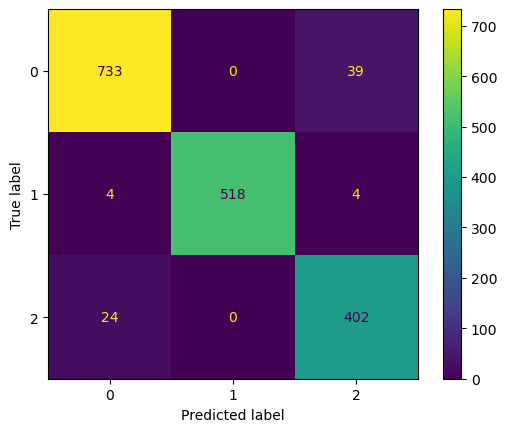

In [159]:
# Read in all data
df_all = get_all(['wilks', 'munoz', 'goetsch'])

# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(df_all['Runner'])

# removing the column runner from df
# as it is of no use now.
df_all.drop('Runner', axis=1, inplace=True)
 
# Appending the array to our dataFrame
df_all.insert(0,'Runner',label)

# Base_line_accuracy
base_line_accuracy = 1-np.sum(df_all['Runner'])/df_all.shape[0]
base_line_accuracy

# Train Test Split
X = df_all[predictors]#  .drop(columns='Runner', axis=1)  # only using variables that are numeric
y = df_all['Runner'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)


# Here we are also making use of Pipeline to create the model to streamline standard scalar and model building
scaler = StandardScaler()
lr = LogisticRegression()
model1 = Pipeline([('standardize', scaler),
                    ('log_reg', lr)])

# Fit the model onto our training data
model1.fit(X_train, y_train)

# Training score
y_train_hat = model1.predict(X_train)
y_train_hat_probs = model1.predict_proba(X_train)[:,1]
train_accuracy = accuracy_score(y_train, y_train_hat)*100
#train_auc_roc = roc_auc_score(y_train, y_train_hat_probs, multi_class = 'ovr')*100  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
matrix = confusion_matrix(y_train, y_train_hat)
print('Confusion matrix:\n', matrix)
print('Training accuracy: %.4f %%' % train_accuracy)

# Confusion matrix
df_confusion = pd.DataFrame(matrix)
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
df_confusion.columns = list(mapping.keys())
df_confusion.index = list(mapping.keys())

plot_confusion_matrix(model1, X_train, y_train)


## Logistic Regression (Guessing Day of Week)

Confusion matrix:
 [[ 0 14  0  2  6  1  0]
 [ 0 57  5 13 21  4  1]
 [ 0 15 29  4  3  8  0]
 [ 0 22 10 20 12  7  1]
 [ 0 43  7  9 28  0  0]
 [ 0 11  5  3 10 17  3]
 [ 1  3  3  0  0  2 27]]
Training accuracy: 41.6862 %


C:\Users\menam\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


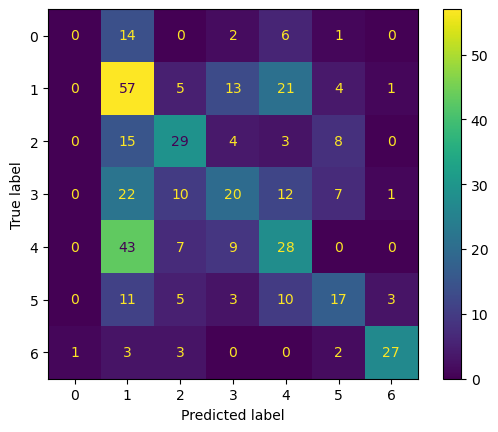

In [26]:

# Train Test Split
X = df_cleaned[predictors]#  .drop(columns='Runner', axis=1)  # only using variables that are numeric
y = df_cleaned['Weekday'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Here we are also making use of Pipeline to create the model to streamline standard scalar and model building
scaler = StandardScaler()
lr = LogisticRegression()
model1 = Pipeline([('standardize', scaler),
                    ('log_reg', lr)])

# Fit the model onto our training data
model1.fit(X_train, y_train)

# Training score
y_train_hat = model1.predict(X_train)
y_train_hat_probs = model1.predict_proba(X_train)[:,1]
train_accuracy = accuracy_score(y_train, y_train_hat)*100
#train_auc_roc = roc_auc_score(y_train, y_train_hat_probs, multi_class = 'ovr')*100  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
matrix = confusion_matrix(y_train, y_train_hat)
print('Confusion matrix:\n', matrix)
print('Training accuracy: %.4f %%' % train_accuracy)

# Confusion matrix
df_confusion = pd.DataFrame(matrix)
#mapping = dict(zip(le.classes_, le.transform(le.classes_)))
#df_confusion.columns = list(mapping.keys())
#df_confusion.index = list(mapping.keys())

plot_confusion_matrix(model1, X_train, y_train)

In [165]:
#label.inverse_transform([0, 1,2])
df_confusion


,goetsch,munoz,wilks
goetsch,733,0,39
munoz,4,518,4
wilks,24,0,402


In [112]:
np.array(pd.Series(df_all.iloc[row][cols], cols)).reshape(1,-1)

array([[587.6, 506, 587.6, 538, 185.0, '2.2', 171.0, 178.0, 0, 0, 1.05,
        620]], dtype=object)

In [67]:
[x for x in predictors if x != target]

['Time',
 'Best Pace',
 'Moving Time',
 'Elapsed Time',
 'Avg Pace',
 'Distance',
 'Max HR',
 'Aerobic TE',
 'Avg Run Cadence',
 'Max Run Cadence',
 'Total Ascent',
 'Total Descent',
 'Avg Stride Length',
 'Min Elevation',
 'Max Elevation']

In [59]:


#df_predicted.drop(df.columns[to_drop], axis=1)
#print(); print(df1.head())
#print(); print(to_drop)
#print(upper_tri)

,Time,Best Pace,Avg Pace,Max HR,Aerobic TE,Avg Run Cadence,Max Run Cadence,Total Ascent,Avg Stride Length,Min Elevation,Max Elevation
316,0.168386,0.419295,0.338505,0.814480,0.480000,0.937173,0.782258,0.038107,0.583333,0.567642,0.610708
90,0.453751,0.431354,0.365303,0.846154,0.760000,0.895288,0.750000,0.062077,0.567708,0.561243,0.607078
134,0.317538,0.346011,0.313117,0.837104,0.700000,0.916230,0.858871,0.071911,0.645833,0.737660,0.809437
491,0.164539,0.404453,0.330748,0.891403,0.520000,0.916230,0.798387,0.024585,0.614583,0.566728,0.601633
186,0.608673,0.410946,0.348378,0.891403,0.980000,0.895288,0.750000,0.229871,0.593750,0.719378,0.794918
...,...,...,...,...,...,...,...,...,...,...,...
8,0.430845,0.367347,0.315233,0.904977,0.820000,0.910995,0.758065,0.060234,0.645833,0.580439,0.601633
73,0.386956,0.404453,0.346262,0.855204,0.780000,0.910995,0.766129,0.057160,0.588542,0.563985,0.622505
400,0.539430,0.414657,0.351199,0.855204,0.960000,0.937173,0.790323,0.014751,0.567708,0.494516,0.529038
118,0.243399,0.478664,0.392102,0.714932,0.420000,0.900524,0.750000,0.042409,0.526042,0.778793,0.809437


In [51]:
# https://stackoverflow.com/questions/69392488/keep-only-one-feature-among-those-ones-which-are-correlated-between-each-other
th = 0.9
target_col = 'Avg HR'
corr_df = corr.abs()

high_cor_xy = set([tuple(sorted(x)) for x in np.argwhere(corr_df.values>=th) if x[0]!=x[1]]) # set of tuples that are the x and y posittion of corr that is greater than our threhshold 
high_cor_col_idx_raw = [(corr_df.columns[x[0]], corr_df.columns[x[1]]) for x in high_cor_xy] # Iterates through high_cor_xy and get the names of correlated columns in a tuple
high_cor_col_idx = [t for t in high_cor_col_idx_raw if target_col not in t] # makes sure the names aren't the target value
#target_corr_dict = corr_df['Time'].to_dict()
#cols_to_drop = [sorted(list(t), key=target_corr_dict.get)[::-1][0] for t in high_cor_col_idx]
cols_to_drop = [sorted(list(t)) for t in high_cor_col_idx]
cor_cols = []
for tup in high_cor_col_idx:
    if tup[0] not in cor_cols:
        cor_cols.append(tup[0])
    if tup[1] not in cor_cols:
        cor_cols.append(tup[1])
cor_cols
groups = {}
for col in cor_cols:
    groups[col] = [x for x in ]
#cols_to_drop
#high_cor_col_idx
#df.drop(cols_to_drop, axis=1)
high_cor_col_idx

[('Min Elevation', 'Max Elevation'),
 ('Total Ascent', 'Total Descent'),
 ('Time', 'Elapsed Time'),
 ('Moving Time', 'Elapsed Time'),
 ('Time', 'Moving Time'),
 ('Time', 'Distance'),
 ('Moving Time', 'Distance'),
 ('Elapsed Time', 'Distance')]

In [28]:
np.argwhere(corr_df.values>=th) # postions where corr_df.values is greater than threshold
#corr_df.values

array([[1.   , 0.115, 0.998, 0.987, 0.015, 0.995, 0.406, 0.836, 0.035,
        0.003, 0.484, 0.497, 0.104, 0.15 , 0.009],
       [0.115, 1.   , 0.126, 0.061, 0.745, 0.07 , 0.125, 0.139, 0.213,
        0.445, 0.073, 0.069, 0.605, 0.086, 0.118],
       [0.998, 0.126, 1.   , 0.986, 0.008, 0.995, 0.403, 0.836, 0.037,
        0.005, 0.488, 0.502, 0.096, 0.149, 0.006],
       [0.987, 0.061, 0.986, 1.   , 0.006, 0.982, 0.393, 0.802, 0.04 ,
        0.049, 0.487, 0.5  , 0.062, 0.148, 0.01 ],
       [0.015, 0.745, 0.008, 0.006, 1.   , 0.046, 0.23 , 0.015, 0.346,
        0.36 , 0.024, 0.013, 0.731, 0.082, 0.096],
       [0.995, 0.07 , 0.995, 0.982, 0.046, 1.   , 0.422, 0.841, 0.018,
        0.022, 0.474, 0.489, 0.051, 0.15 , 0.013],
       [0.406, 0.125, 0.403, 0.393, 0.23 , 0.422, 1.   , 0.7  , 0.03 ,
        0.072, 0.206, 0.218, 0.023, 0.102, 0.042],
       [0.836, 0.139, 0.836, 0.802, 0.015, 0.841, 0.7  , 1.   , 0.031,
        0.028, 0.399, 0.417, 0.141, 0.119, 0.008],
       [0.035, 0.213, 0.

In [4]:
normalize(X_train, axis = 0, return_norm = False, copy = True) # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html

X_train

NameError: name 'X_train' is not defined

In [13]:
# how many types of data are there
unique = {}
for col in predictors:
    unique[col] = len(df_cleaned[col].unique())

for col in unique.keys():
    if unique[col] == 1:
        predictors.remove(col)
        

['Avg HR',
 'Avg Pace',
 'Time',
 'Best Pace',
 'Moving Time',
 'Elapsed Time',
 'Avg Pace',
 'Distance',
 'Max HR',
 'Aerobic TE',
 'Avg Run Cadence',
 'Max Run Cadence',
 'Total Ascent',
 'Total Descent',
 'Avg Stride Length',
 'Min Elevation',
 'Max Elevation']

## No Aerobic TE
Our linear regression model works pretty well on the training data! It could do definantly do better. However, there are two variables Max HR and Aerobic TE that are also tracking HR, so these should be highly correlated with the Avg HR. I wonder what the model looks like without them, but for now they are a sanity check since they SHOULD be the strongest coeffecients. 

In [25]:

print(print('%s: Without Aerobic TE and without Max HR'%name)

predictors = ['Avg HR','Avg Pace','Time','Best Pace','Moving Time', 'Elapsed Time', 'Avg Pace',
    'Distance','Avg Run Cadence', 'Max Run Cadence',
    'Total Ascent','Total Descent', 'Avg Stride Length', 'Avg Ground Contact Time','Min Temp','Max Temp', 'Min Elevation',
       'Max Elevation']
df_predictors = df_cleaned[predictors]
X = df_predictors.iloc[:,1:]   #
y = df_predictors.iloc[:,0] # Avg HR is at the zeroth 
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=5)
regr = LinearRegression()
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))
print(regr.coef_)
#print(regr.coef_,regr.intercept_)
pd.DataFrame(pd.Series(regr.coef_,X_train.columns), columns = [name])
#pd.DataFrame({col: [coef] for col, coef in zip(X_train.columns, regr.coef_)}, columns = name).T


munoz
Without Aerobic TE and without Max HR
0.11344542479497222
[ 5.45369061e-03 -1.36182884e-02  1.66170680e-02  1.01469543e-02
 -1.39481319e-03  5.45369061e-03  2.60566414e+00 -2.89188375e-01
  9.29607399e-02  4.71548363e-03 -4.74937450e-03  1.79197671e+01
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.04099216e-03
  6.20570288e-03]


,munoz
Avg Pace,0.005454
Time,-0.013618
Best Pace,0.016617
Moving Time,0.010147
Elapsed Time,-0.001395
Avg Pace,0.005454
Distance,2.605664
Avg Run Cadence,-0.289188
Max Run Cadence,0.092961
Total Ascent,0.004715


In [14]:
predictors = ['Weekday','Avg HR','Avg Pace','Time','Best Pace','Moving Time', 'Elapsed Time', 'Avg Pace',
    'Distance',  'Max HR','Aerobic TE','Avg Run Cadence', 'Max Run Cadence',
    'Total Ascent','Total Descent', 'Avg Stride Length', 'Avg Ground Contact Time','Min Temp','Max Temp', 'Min Elevation',
       'Max Elevation']
df_predictors = df_cleaned[predictors]
X = df_predictors.iloc[:,1:]   #
y = df_predictors.iloc[:,0] # Avg HR is at the zeroth 
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=5)

scaler = StandardScaler()
lr = LogisticRegression()
model1 = Pipeline([('standardize', scaler),
                    ('log_reg', lr)])

## Junk

In [15]:
df_cleaned[df_cleaned['Avg HR'] == 0]

,Activity Type,Date,Favorite,Title,Distance,Calories,Time,Avg HR,Max HR,Aerobic TE,...,Number of Laps,Max Temp,Moving Time,Elapsed Time,Min Elevation,Max Elevation,Day,Hour,Minute,Weekday
1,Running,2022-10-15 09:54:29,False,Romeoville Running,9.180000,1050,4105.000000,0,0,2.1,...,10,0.000000,4099.000000,4131.000000,600,686,Saturday,9,54,5
10,Running,2022-10-10 07:59:32,False,Romeoville Running,6.050000,691,2694.000000,0,0,1.2,...,7,0.000000,2692.000000,2694.000000,616,669,Monday,7,59,0
13,Running,2022-10-08 09:45:00,False,Lewis Crossover,4.970000,529,1609.000000,0,0,0,...,1,0.000000,0.000000,1609.000000,0,0,Saturday,9,45,5
31,Running,2022-09-28 06:37:49,False,Romeoville Running,6.000000,686,2831.000000,0,0,1.3,...,7,0.000000,2826.000000,2831.000000,600,686,Wednesday,6,37,2
46,Running,2022-09-16 17:00:00,False,Cooldown,1.000000,101,480.000000,0,0,0,...,1,0.000000,0.000000,28800.000000,0,0,Friday,17,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047,Running,2020-03-29 08:41:44,False,Plainfield Running,1.040000,113,9.000000,0,0,0,...,2,0.000000,551.000000,9.000000,600,604,Sunday,8,41,6
1049,Running,2020-03-27 14:27:41,False,DuPage County Running,7.570000,827,3361.000000,0,0,0,...,8,0.000000,3359.000000,3361.000000,663,702,Friday,14,27,4
1050,Running,2020-03-26 08:40:49,False,8 Strides,0.500000,67,133.000000,0,0,0,...,15,0.000000,9.000000,618.000000,600,604,Thursday,8,40,3
1057,Running,2020-03-22 09:18:37,False,DuPage County Running,10.010000,1094,4021.000000,0,0,0,...,11,0.000000,4017.000000,4021.000000,594,780,Sunday,9,18,6


In [94]:
df_cleaned['Aerobic TE'].unique()

array(['2.5', '3.1', '2.6', '2', '4.1', '4', '1.7', '2.9', '5', '3',
       '1.1', '4.4', '2.4', '4.3', '3.7', '3.5', '1.2', '3.4', '2.7',
       '3.3', '2.2', '4.6', '4.2', '3.9', '1.3', '3.8', '2.8', '1.5',
       '2.3', '3.2', '4.5', '3.6', '2.1', '1', '4.9', '4.7', '4.8', '1.8',
       '1.6', '1.9'], dtype=object)

In [70]:
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y = 1 * x_0 + 2 * x_1 + 3
y = np.dot(X, np.array([1, 2])) + 3 # dot product
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.coef_)
print(reg.intercept_)
print(reg.predict(np.array([[3, 5]])))

1.0
[1. 2.]
3.0000000000000018
[16.]


In [69]:
print(y)
print(X)
print(np.array([1, 2]))

[ 6  8  9 11]
[[1 1]
 [1 2]
 [2 2]
 [2 3]]
[1 2]


In [83]:
df_cleaned[df_cleaned['Total Ascent'] == '--']
df_cleaned['Total Ascent'].replace('--',0)

0      668
1       88
2      102
3      333
4       20
      ... 
755     41
756     52
757    226
758    288
759    498
Name: Total Ascent, Length: 653, dtype: object

In [78]:
df_cleaned

SyntaxError: invalid syntax (1950948023.py, line 1)

In [69]:
df_cleaned['Date'].dt.day_name()
df_cleaned['Date'].dt.hour
df_cleaned['Dat']

# df['dates'] = df['time'].dt.date
# df['hour'] = df['time'].dt.hour
# df['minute'] = df['time'].dt.minute
# df['second'] = df['time'].dt.second

0      Saturday
1        Friday
2        Friday
3      Thursday
4      Thursday
         ...   
755      Sunday
756      Sunday
757    Saturday
758      Friday
759    Thursday
Name: Date, Length: 653, dtype: object

In [58]:
df_cleaned['Date'].apply(lambda x: x.day_name())

0      Saturday
1        Friday
2        Friday
3      Thursday
4      Thursday
         ...   
755      Sunday
756      Sunday
757    Saturday
758      Friday
759    Thursday
Name: Date, Length: 653, dtype: object

In [45]:
df_cleaned.dtypes

Activity Type                object
Date                         object
Favorite                       bool
Title                        object
Distance                    float64
Calories                     object
Time                        float64
Avg HR                        int64
Max HR                        int64
Aerobic TE                   object
Avg Run Cadence               int64
Max Run Cadence               int64
Avg Pace                      int64
Best Pace                     int64
Total Ascent                 object
Total Descent                object
Avg Stride Length           float64
Avg Vertical Ratio          float64
Avg Vertical Oscillation    float64
Avg Ground Contact Time       int64
Avg Run Cadence.1             int64
Max Run Cadence.1             int64
Training Stress Score®      float64
Avg Power                     int64
Max Power                     int64
Grit                        float64
Flow                        float64
Avg. Swolf                  

In [30]:
df_activities[time_cols]
#split_time(df_activities['Best Lap Time'][0])
'...'.count('.')

3

In [6]:
df_activities
df_activities['Best Pace'].replace(['--'], ['00:00'], inplace = True)
df_activities = clean_data(df_activities)
df_activities['Max Elevation'] = df_activities['Max Elevation'].apply(lambda x: re.sub(',','', x))
df_activities['Min Elevation'] = df_activities['Min Elevation'].apply(lambda x: re.sub(',','', x))
df_activities['Calories'] = df_activities['Calories'].apply(lambda x: re.sub(',','', x))
df_activities['Total Ascent'] = df_activities['Total Ascent'].apply(lambda x: re.sub(',','', x))
df_activities['Total Descent'] = df_activities['Total Descent'].apply(lambda x: re.sub(',','', x))

df_activities.replace(['--'],[0], inplace = True) # please fix later

,Activity Type,Date,Favorite,Title,Distance,Calories,Time,Avg HR,Max HR,Aerobic TE,...,Min Temp,Surface Interval,Decompression,Best Lap Time,Number of Laps,Max Temp,Moving Time,Elapsed Time,Min Elevation,Max Elevation
0,Running,2022-10-15 09:32:37,False,Pueblo Running,13.03,1041,5781.0,148,191,3.4,...,0.0,0:00,No,00:13.73.4,14,0.0,5775.0,7718.0,4782,4951
1,Running,2022-10-14 19:19:02,False,Pueblo Running,8.16,512,3647.0,126,145,1.9,...,0.0,0:00,No,00:01.08.2,10,0.0,3620.0,5759.0,4821,4883
2,Running,2022-10-14 07:45:40,False,Pueblo Running,4.01,354,1649.0,143,156,2.4,...,0.0,0:00,No,00:02.02.8,5,0.0,1648.0,1662.0,4696,4814
3,Running,2022-10-13 15:44:13,False,Pueblo Running,8.25,513,3795.0,122,144,1.7,...,0.0,0:00,No,01:56.45.4,9,0.0,3786.0,4524.0,4704,4938
4,Running,2022-10-13 05:43:04,False,Pueblo Running,4.20,332,1844.0,132,145,1.9,...,0.0,0:00,No,01:24.59.5,5,0.0,1841.0,1858.0,4858,4882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,Running,2021-04-25 09:40:02,False,Pueblo Running,2.10,108,939.0,113,135,1.2,...,0.0,0:00,No,00:06.36,6,0.0,819.0,939.0,4862,4881
756,Running,2021-04-25 09:02:45,False,Pueblo Running,1.91,155,875.0,134,145,1.7,...,0.0,0:00,No,06:53.07.5,2,0.0,875.0,878.0,4805,4857
757,Running,2021-04-24 07:00:16,False,Pueblo Running,4.16,258,1857.0,126,148,1.6,...,0.0,0:00,No,01:16.63,5,0.0,1855.0,1857.0,4747,4911
758,Running,2021-04-23 15:39:54,False,Pueblo Running,6.01,415,2819.0,131,144,1.9,...,0.0,0:00,No,00:02.66,7,0.0,2816.0,2875.0,4748,4933


In [64]:
df_who.iloc[:,10:len(df_who.columns)]

,Avg Run Cadence,Max Run Cadence,Avg Pace,Best Pace,Total Ascent,Total Descent,Avg Stride Length,Avg Vertical Ratio,Avg Vertical Oscillation,Avg Ground Contact Time,...,Min Temp,Surface Interval,Decompression,Best Lap Time,Number of Laps,Max Temp,Moving Time,Elapsed Time,Min Elevation,Max Elevation
0,170,205,444,226,668,647,1.28,0.0,0.0,0,...,0.0,0:00,No,00:13.73.4,14,0.0,5775.0,7718.0,4782,4951
1,173,211,447,221,88,78,1.24,0.0,0.0,0,...,0.0,0:00,No,00:01.08.2,10,0.0,3620.0,5759.0,4821,4883
2,173,179,411,371,102,112,1.36,0.0,0.0,0,...,0.0,0:00,No,00:02.02.8,5,0.0,1648.0,1662.0,4696,4814
3,171,180,460,266,333,332,1.23,0.0,0.0,0,...,0.0,0:00,No,01:56.45.4,9,0.0,3786.0,4524.0,4704,4938
4,173,179,439,408,20,18,1.27,0.0,0.0,0,...,0.0,0:00,No,01:24.59.5,5,0.0,1841.0,1858.0,4858,4882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,166,198,447,254,41,45,1.25,0.0,0.0,0,...,0.0,0:00,No,00:06.36,6,0.0,819.0,939.0,4862,4881
756,173,180,458,443,52,55,1.22,0.0,0.0,0,...,0.0,0:00,No,06:53.07.5,2,0.0,875.0,878.0,4805,4857
757,172,178,446,400,226,227,1.26,0.0,0.0,0,...,0.0,0:00,No,01:16.63,5,0.0,1855.0,1857.0,4747,4911
758,170,176,469,434,288,285,1.21,0.0,0.0,0,...,0.0,0:00,No,00:02.66,7,0.0,2816.0,2875.0,4748,4933


In [65]:
predictors = ['Avg Pace','Time','Best Pace','Moving Time', 'Elapsed Time', 'Avg Pace',
    'Distance',  'Max HR','Aerobic TE','Avg Run Cadence', 'Max Run Cadence',
    'Total Ascent','Total Descent', 'Avg Stride Length', 'Avg Ground Contact Time','Min Temp','Max Temp', 'Min Elevation',
       'Max Elevation']
df_predictors = df_who[predictors]

In [66]:
X = df_predictors.iloc[:,1:]   #.reshape(-1,1)  why did we reshape? should I transpose this value
y = df_predictors.iloc[:,1]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=5)
# https://www.geeksforgeeks.org/how-to-split-a-dataset-into-train-and-test-sets-using-python/

In [67]:
# I think you need to scale this miles - Irena

predictors = ['Avg Pace','Time','Best Pace','Moving Time', 'Elapsed Time', 'Avg Pace',
    'Distance',  'Max HR','Aerobic TE','Avg Run Cadence', 'Max Run Cadence',
    'Total Ascent','Total Descent', 'Avg Stride Length', 'Avg Ground Contact Time','Min Temp','Max Temp', 'Min Elevation',
       'Max Elevation']
df_predictors = df_who[predictors]
X = df_predictors.iloc[:,1:]   #.reshape(-1,1)  why did we reshape? should I transpose this value
y = df_predictors.iloc[:,1]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=5)
# https://www.geeksforgeeks.org/how-to-split-a-dataset-into-train-and-test-sets-using-python/
regr = LinearRegression()
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

1.0


In [69]:
regr.coef_

array([ 1.00000000e+00,  9.56163150e-16, -1.54701111e-16,  2.49028042e-16,
        2.08071654e-15,  1.84717251e-13,  4.42921068e-16,  1.10410845e-15,
       -7.87997380e-16,  8.59200786e-16, -1.66171989e-16,  1.61369343e-17,
        4.21077562e-14,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.60514591e-16,  1.81518432e-16])

In [27]:
df_predictors[['Min Elevation','Max Elevation']].replace(',','')
#.apply(lambda x: re.sub(x,))

,Min Elevation,Max Elevation
0,"4,782","4,951"
1,"4,821","4,883"
2,"4,696","4,814"
3,"4,704","4,938"
4,"4,858","4,882"
...,...,...
755,"4,862","4,881"
756,"4,805","4,857"
757,"4,747","4,911"
758,"4,748","4,933"


## Understanding The Data
I don't know if we are supposed to be allowed to look at the data before we run some models on it, but I was curious at what I could see. 

In [ ]:
#df_who['Best Pace'].unique()
#df_who[predictors].describe()
#df_who[df_who['Distance'] > 1.5][predictors].describe()
#df_who[df_who['Distance'] > 1.5][predictors].median()
df_who['Distance'].hist()
#df_who['Distance'].dtypes

In [8]:
df_who[df_who['Avg Pace'] < 300].sort_values('Avg Pace')[predictors]

,Time,Best Pace,Moving Time,Elapsed Time,Avg Pace,Distance,Max HR,Aerobic TE,Avg Run Cadence,Max Run Cadence,Total Ascent,Total Descent,Avg Stride Length,Avg Ground Contact Time,Min Temp,Max Temp,Min Elevation,Max Elevation
479,2.0,178,1.0,661.0,254,0.48,0,--,195,245,--,--,1.92,0,0.0,0.0,604,604
487,1.0,179,1.0,9.0,258,0.40,0,--,198,228,--,--,1.86,0,0.0,0.0,604,604
497,1.0,175,74.0,6.0,259,0.32,0,--,192,235,--,--,1.95,0,0.0,0.0,604,604
1050,133.0,202,9.0,618.0,266,0.50,0,--,158,226,13,10,0.75,0,0.0,0.0,600,604
406,2.0,154,0.0,623.0,271,0.46,154,1.0,161,241,--,--,2.24,0,0.0,0.0,650,655
772,4.0,267,4.0,4.0,280,1.01,0,--,196,217,--,3,1.76,0,0.0,0.0,645,656
774,9.0,247,573.0,9.0,285,2.04,0,--,195,260,7,8,1.74,0,0.0,0.0,645,656
16,1.0,222,53.0,5.0,289,0.23,117,0.1,154,233,--,--,2.18,0,0.0,0.0,621,630
734,918.0,256,918.0,918.0,290,3.17,0,--,188,208,13,11,1.77,0,0.0,0.0,645,656
194,916.0,0,0.0,916.0,295,3.11,0,--,0,0,--,--,0.00,0,0.0,0.0,--,--


In [5]:
time_hr = ['Avg HR','Time','Best Pace','Moving Time', 'Elapsed Time', 'Avg Pace']

### Scatter Plots

In [35]:
var1 = 'Day'
#df_cleaned.set_index(var1).reindex(var1).reset_index()

index = pd.Index = df_cleaned['Date'].dt.weekday.unique()
data = df_cleaned['Day'].unique()
pd.Series(data, index).sort_index()

0       Monday
1      Tuesday
2    Wednesday
3     Thursday
4       Friday
5     Saturday
6       Sunday
dtype: object

C:\Users\menam\AppData\Local\Temp\ipykernel_5336\1498736731.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(days);


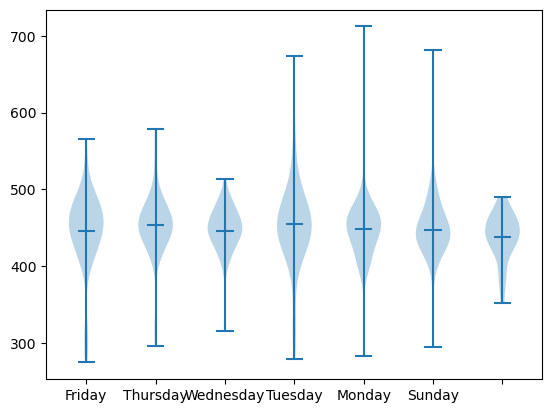

In [116]:
#https://stackabuse.com/matplotlib-violin-plot-tutorial-and-examples/
# There should be an easier way to do this
days = df_cleaned['Day'].unique().sort_values()
day_data = []
for day in days:
    day_data.append(df_cleaned[df_cleaned['Day'] == day]['Avg Pace'].tolist())
    
fig, ax = plt.subplots()
ax.violinplot(day_data, showmeans = True)
ax.set_xticklabels(days);

In [124]:
days = df_cleaned['Day'].sort_values('Day', axis = 1).unique()
days

TypeError: sort_values() got multiple values for argument 'axis'

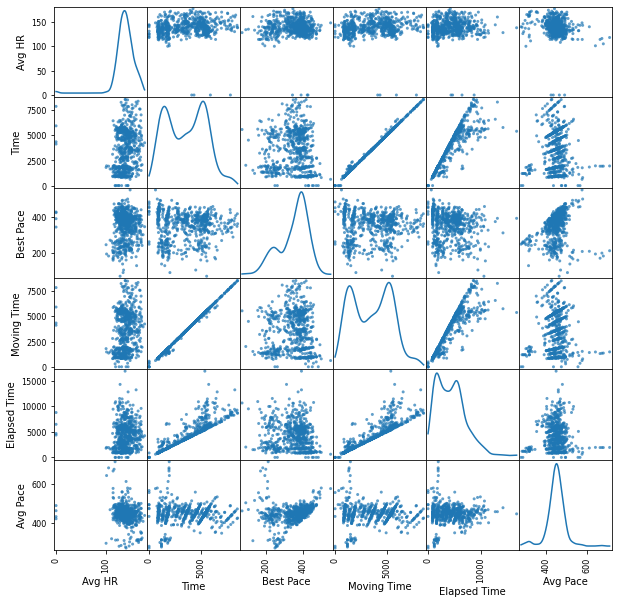

In [6]:
from pandas.plotting import scatter_matrix

scatter_matrix(df[time_hr], alpha=0.7, figsize=(10, 10), diagonal='kde');
# https://en.wikipedia.org/wiki/Kernel_density_estimation